In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Convlution
[batch_size, channels, height, width]

In [2]:
import torch.nn.functional as F
x = torch.tensor([[1.,2.,3.],
                  [4.,5.,6.],
                  [7.,8.,9.]]).unsqueeze(0).unsqueeze(0)

kernel = torch.tensor([[1.,0.],
                      [0.,-1.]]).unsqueeze(0).unsqueeze(0)

output = F.conv2d(x, kernel, stride=1, padding=0)
print("Input:", x)
print("kernel:", kernel)
print("output:",output)


Input: tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
kernel: tensor([[[[ 1.,  0.],
          [ 0., -1.]]]])
output: tensor([[[[-4., -4.],
          [-4., -4.]]]])


# Dataset Preparation

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


# Define the Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,8,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,3,padding=1)
        self.fc1 = nn.Linear(16*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Train

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/3, Loss: 0.24591411896514645
Epoch 2/3, Loss: 0.06454688455087385
Epoch 3/3, Loss: 0.047983183787995654


# Test

In [6]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 98.71%


# Exercise 1: Visualize Featue Maps

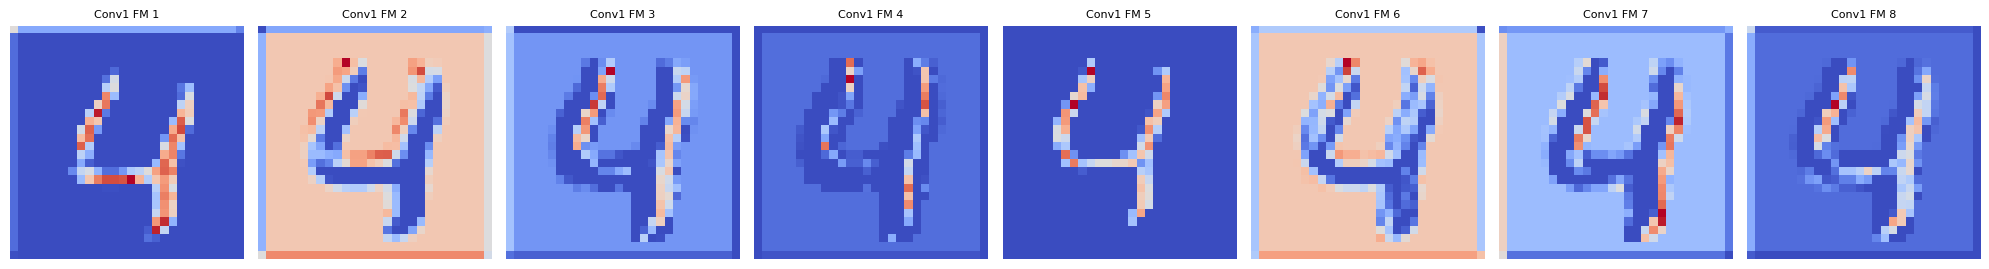

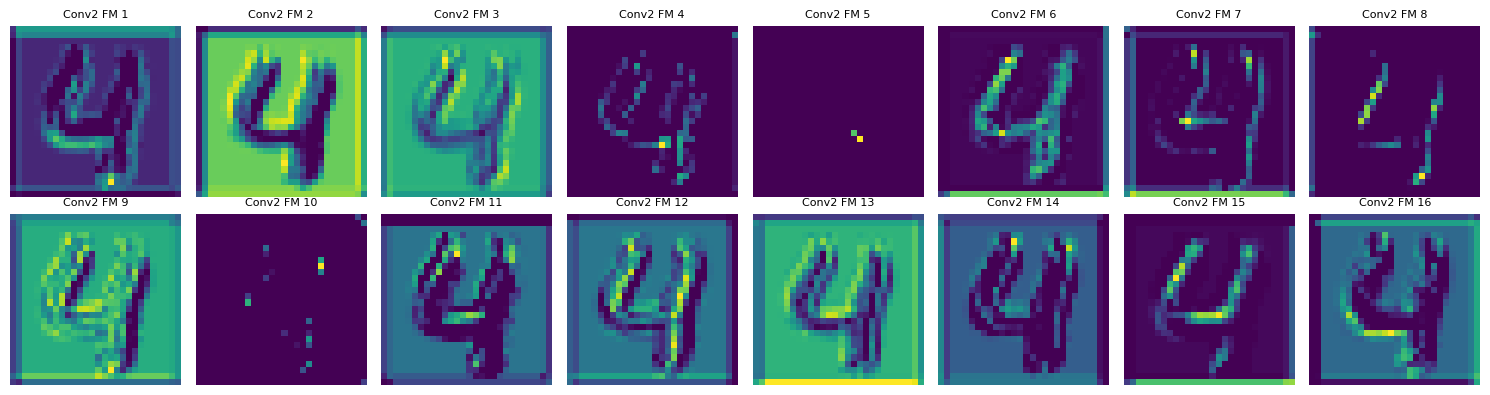

In [7]:
img_sample, lbl = test_dataset[4]
img_sample = img_sample.unsqueeze(0).to(device)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x1 = torch.relu(self.conv1(x))
        x2 = torch.relu(self.conv2(x1))
        return x1, x2

model = SimpleCNN().to(device)
model.eval()

with torch.no_grad():
    fmap1, fmap2 = model(img_sample)

fmap1 = fmap1.squeeze(0).cpu()
fmap2 = fmap2.squeeze(0).cpu()

# نمایش Feature Map conv1
fig, axes = plt.subplots(1, fmap1.shape[0], figsize=(20,3))
for idx, fmap in enumerate(fmap1):
    axes[idx].imshow(fmap, cmap='coolwarm')
    axes[idx].axis('off')
    axes[idx].set_title(f'Conv1 FM {idx+1}', fontsize=8)
plt.tight_layout()
plt.show()

# نمایش Feature Map conv2
fig, axes = plt.subplots(2, fmap2.shape[0]//2, figsize=(15,4))
for idx, fmap in enumerate(fmap2):
    ax = axes[idx//(fmap2.shape[0]//2), idx%(fmap2.shape[0]//2)]
    ax.imshow(fmap, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Conv2 FM {idx+1}', fontsize=8)
plt.tight_layout()
plt.show()


# Exercise 2:

1. Try increasing num_epochs to 5 or 10 — observe training accuracy.

2. Replace ReLU with Sigmoid or Tanh — what happens?

3. Change kernel size to 5x5 — does performance improve?

4. Add a dropout layer after fc1.

5. Replace Adam with SGD (different learning rate).

6. Train a deeper CNN on CIFAR-10 using datasets.CIFAR10.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import numpy as np



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(f"Using device: {device}\n")

num_epochs = 5
criterion = nn.CrossEntropyLoss()

def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, num_epochs, model_name):
    start_time = time.time()
    print("="*60)
    print(f"--- Starting Training: {model_name} ---")
    print(f"Optimizer: {type(optimizer).__name__}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.2f}%')

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    end_time = time.time()
    print(f'Total Training Time: {end_time - start_time:.2f}s')
    print(f'*** Final Test Accuracy: {test_accuracy:.2f}% ***')
    return test_accuracy


transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_mnist = datasets.MNIST('./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = datasets.MNIST('./data', train=False, transform=transform_mnist)

train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=1000, shuffle=False)
print("MNIST Data Loaded.")

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = datasets.CIFAR10('./data', train=False, transform=transform_cifar)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=128, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=1000, shuffle=False)
print("CIFAR-10 Data Loaded.")



class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_base = BaselineCNN().to(device)
optimizer_base = optim.Adam(model_base.parameters(), lr=0.001)

accuracy_base = train_and_evaluate(
    model_base, optimizer_base, criterion, train_loader_mnist, test_loader_mnist, num_epochs,
    "1. Baseline Model (ReLU, 3x3, Adam, MNIST)"
)



class ModifiedCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x)))
        x = self.pool(torch.sigmoid(self.conv2(x)))

        x = x.view(-1, 16 * 7 * 7)

        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x

model_mod = ModifiedCNN().to(device)
optimizer_mod = optim.SGD(model_mod.parameters(), lr=0.01)

accuracy_mod = train_and_evaluate(
    model_mod, optimizer_mod, criterion, train_loader_mnist, test_loader_mnist, num_epochs,
    "2. Modified Model (Sigmoid, 5x5, Dropout, SGD, MNIST)"
)



class DeeperCIFARCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))

        x = x.view(-1, 128 * 8 * 8)

        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_cifar = DeeperCIFARCNN().to(device)
optimizer_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)

accuracy_cifar = train_and_evaluate(
    model_cifar, optimizer_cifar, criterion, train_loader_cifar, test_loader_cifar, num_epochs,
    "3. Deeper CNN for CIFAR-10 (3->10 classes, Batch Norm, Adam)"
)


print("\n\n" + "="*60)
print(" Summary of Results After 5 Epochs")
print("="*60)
print(f"1. Baseline (ReLU, 3x3, Adam, MNIST):   Test Acc = {accuracy_base:.2f}%")
print(f"2. Modified (Sigmoid, 5x5, SGD, MNIST):  Test Acc = {accuracy_mod:.2f}%")
print(f"3. Deeper CIFAR-10 (ReLU, Adam):         Test Acc = {accuracy_cifar:.2f}%")
print("----------------------------------------------------------------")

print("\nObservation Notes:")
print(" - Comparison (1 vs 2): Model 1 should be significantly better due to ReLU (avoids vanishing gradients) and the powerful Adam optimizer.")
print(" - CIFAR-10 (3): Accuracy will be lower than MNIST due to the increased complexity of images and 3 color channels.")

Using device: cuda

MNIST Data Loaded.
CIFAR-10 Data Loaded.
--- Starting Training: 1. Baseline Model (ReLU, 3x3, Adam, MNIST) ---
Optimizer: Adam, Learning Rate: 0.001
Epoch [1/5] | Loss: 0.2099 | Train Acc: 93.63%
Epoch [2/5] | Loss: 0.0643 | Train Acc: 97.97%
Epoch [3/5] | Loss: 0.0462 | Train Acc: 98.54%
Epoch [4/5] | Loss: 0.0352 | Train Acc: 98.90%
Epoch [5/5] | Loss: 0.0284 | Train Acc: 99.07%
Total Training Time: 69.16s
*** Final Test Accuracy: 98.97% ***
--- Starting Training: 2. Modified Model (Sigmoid, 5x5, Dropout, SGD, MNIST) ---
Optimizer: SGD, Learning Rate: 0.01
Epoch [1/5] | Loss: 2.3270 | Train Acc: 10.21%
Epoch [2/5] | Loss: 2.3122 | Train Acc: 10.30%
Epoch [3/5] | Loss: 2.3076 | Train Acc: 10.46%
Epoch [4/5] | Loss: 2.3042 | Train Acc: 10.73%
Epoch [5/5] | Loss: 2.3034 | Train Acc: 10.57%
Total Training Time: 69.79s
*** Final Test Accuracy: 11.35% ***
--- Starting Training: 3. Deeper CNN for CIFAR-10 (3->10 classes, Batch Norm, Adam) ---
Optimizer: Adam, Learning Ra

## Pretrained Models

In [ ]:
import torchvision.models as models
from torchvision import transforms, datasets

# Example: ResNet18 pretrained on ImageNet
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prepare Dataset


In [ ]:
transform_cifar = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=64, shuffle=False)

resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

100%|██████████| 170M/170M [01:01<00:00, 2.76MB/s]


# Prepare the Model

# Freeze and Train

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/2, Loss: 0.037169699085755216
Epoch 2/2, Loss: 0.03716176200732797


# Test


# Exercise 3:

1. Unfreeze the last convolutional block of ResNet, retrain for 3–5 epochs. Compare performance to frozen-feature training.
2. Replace the optimizer: Try torch.optim.SGD with momentum=0.9 Observe how convergence speed changes.
3. Replace ResNet with VGG16.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
num_epochs_fine_tune = 4

TRANSFORM_SIZE = 64
BATCH_SIZE = 32
print(f"Using device: {device} | Image size: {TRANSFORM_SIZE}x{TRANSFORM_SIZE} | Batch size: {BATCH_SIZE}")

def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, num_epochs, model_name):
    start_time = time.time()
    print("="*80)
    print(f"--- Starting Training: {model_name} ---")
    print(f"Optimizer: {type(optimizer).__name__}, LR: {optimizer.param_groups[0]['lr']}")

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.2f}%')

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    end_time = time.time()
    print(f'Total Training Time: {end_time - start_time:.2f}s')
    print(f'*** Final Test Accuracy: {test_accuracy:.2f}% ***')
    return test_accuracy

transform_cifar = transforms.Compose([
    transforms.Resize((TRANSFORM_SIZE, TRANSFORM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=BATCH_SIZE, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=BATCH_SIZE, shuffle=False)
print("CIFAR-10 Data Loaders initialized.")

Using device: cuda | Image size: 64x64 | Batch size: 32
CIFAR-10 Data Loaders initialized.


In [20]:
BATCH_SIZE = 16
LR_FINE_TUNE = 0.00005

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=BATCH_SIZE, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=BATCH_SIZE, shuffle=False)
print(f"Batch Size set to {BATCH_SIZE}.")



resnet_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_ft.fc = nn.Linear(resnet_ft.fc.in_features, 10)
resnet_ft = resnet_ft.to(device)

for param in resnet_ft.parameters():
    param.requires_grad = False

for param in resnet_ft.layer4[1].parameters():
    param.requires_grad = True

for param in resnet_ft.fc.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.Adam(resnet_ft.parameters(), lr=LR_FINE_TUNE)

accuracy_ft = train_and_evaluate(
    resnet_ft, optimizer_ft, loss_fn, train_loader_cifar, test_loader_cifar, num_epochs_fine_tune,
    "A. ResNet18 Fine-Tuning (Minimally Unfrozen - Last Block Only)"
)
print(f"Result A (Minimally Unfrozen): {accuracy_ft:.2f}%")

Batch Size set to 16.
--- Starting Training: A. ResNet18 Fine-Tuning (Minimally Unfrozen - Last Block Only) ---
Optimizer: Adam, LR: 5e-05
Epoch [1/4] | Loss: 0.9585 | Train Acc: 67.03%
Epoch [2/4] | Loss: 0.7069 | Train Acc: 75.49%
Epoch [3/4] | Loss: 0.6019 | Train Acc: 79.25%
Epoch [4/4] | Loss: 0.5272 | Train Acc: 81.75%
Total Training Time: 178.16s
*** Final Test Accuracy: 78.82% ***
Result A (Minimally Unfrozen): 78.82%


In [21]:

resnet_sgd = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_sgd.fc = nn.Linear(resnet_sgd.fc.in_features, 10)
resnet_sgd = resnet_sgd.to(device)

for param in resnet_sgd.parameters():
    param.requires_grad = False
for param in resnet_sgd.fc.parameters():
    param.requires_grad = True

optimizer_sgd = torch.optim.SGD(resnet_sgd.parameters(), lr=0.01, momentum=0.9)

accuracy_sgd = train_and_evaluate(
    resnet_sgd, optimizer_sgd, loss_fn, train_loader_cifar, test_loader_cifar, num_epochs_fine_tune,
    "B. ResNet18 Frozen FC (SGD with Momentum 0.9)"
)
print(f"Result B: {accuracy_sgd:.2f}%")

--- Starting Training: B. ResNet18 Frozen FC (SGD with Momentum 0.9) ---
Optimizer: SGD, LR: 0.01
Epoch [1/4] | Loss: 3.3741 | Train Acc: 48.27%
Epoch [2/4] | Loss: 3.5101 | Train Acc: 49.86%
Epoch [3/4] | Loss: 3.5902 | Train Acc: 49.81%
Epoch [4/4] | Loss: 3.6327 | Train Acc: 49.96%
Total Training Time: 148.35s
*** Final Test Accuracy: 51.15% ***
Result B: 51.15%


In [23]:

vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 10)
vgg16 = vgg16.to(device)

for param in vgg16.parameters():
    param.requires_grad = False
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True

optimizer_vgg = torch.optim.Adam(vgg16.parameters(), lr=0.001)

accuracy_vgg = train_and_evaluate(
    vgg16, optimizer_vgg, loss_fn, train_loader_cifar, test_loader_cifar, num_epochs_fine_tune,
    "C. VGG16 Frozen Feature Training (Adam)"
)
print(f"Result C: {accuracy_vgg:.2f}%")

--- Starting Training: C. VGG16 Frozen Feature Training (Adam) ---
Optimizer: Adam, LR: 0.001
Epoch [1/4] | Loss: 1.4165 | Train Acc: 60.35%
Epoch [2/4] | Loss: 1.5002 | Train Acc: 62.02%
Epoch [3/4] | Loss: 1.5223 | Train Acc: 62.69%
Epoch [4/4] | Loss: 1.5515 | Train Acc: 62.79%
Total Training Time: 225.38s
*** Final Test Accuracy: 68.53% ***
Result C: 68.53%
